# Homework 10 - CIFAR10 Image Classification with PyTorch

## About

The goal of the homework is to train a convolutional neural network on the standard CIFAR10 image classfication dataset.

When solving machine learning tasks using neural networks, one typically starts with a simple network architecture and then improves the network by adding new layers, retraining, adjusting parameters, retraining, etc.  We attempt to illustrate this process below with several architecture improvements.


## Dev Environment
### Working on Google Colab
You may choose to work locally or on Google Colaboratory. You have access to free compute through this service.   Colab is recommended since it will be setup correctly and will have access to GPU resources.
1. Visit https://colab.research.google.com/drive 
2. Navigate to the **`Upload`** tab, and upload your `HW10.ipynb`
3. Now on the top right corner, under the `Comment` and `Share` options, you should see a `Connect` option. Once you are connected, you will have access to a VM with 12GB RAM, 50 GB disk space and a single GPU. The dropdown menu will allow you to connect to a local runtime as well.

**Notes:** 
* **If you do not have a working setup for Python 3, this is your best bet. It will also save you from heavy installations like `tensorflow` if you don't want to deal with those.**
* ***There is a downside*. You can only use this instance for a single 12-hour stretch, after which your data will be deleted, and you would have redownload all your datasets, any libraries not already on the VM, and regenerate your logs**.


### Installing PyTorch and Dependencies

The instructions for installing and setting up PyTorch can be found at https://pytorch.org/get-started/locally/. Make sure you follow the instructions for your machine. For any of the remaining libraries used in this assignment:
* We have provided a `hw8_requirements.txt` file on the homework web page. 
* Download this file, and in the same directory you can run `pip3 install -r hw8_requirements.txt`
​
Check that PyTorch installed correctly by running the following:

In [1]:
import torch
torch.rand(5, 3)

tensor([[0.9330, 0.9561, 0.2612],
        [0.5606, 0.3309, 0.5689],
        [0.4912, 0.5507, 0.6878],
        [0.1309, 0.0729, 0.4885],
        [0.8768, 0.7568, 0.4088]])

## Part 0 Imports and Basic Setup  (5 Points)

First, import the required libraries as follows. The libraries we will use will be the same as those in HW8. 

In [0]:
import numpy as np
import torch
from torch import nn
from torch import optim

import matplotlib.pyplot as plt

**GPU Support**

Training of large network can take a long time. PyTorch supports GPU with just a small amount of effort.

When creating our networks, we will call 
`net.to(device)` to tell the network to train on the GPU, if one is available.  Note, if the network utilizes the GPU, it is important that any tensors we use with it (such as the data) also reside on the CPU.  Thus, a call like `images = images.to(device)` is necessary with any data we want to use with the GPU.

Note: If you can't get access to a GPU, don't worry to much.  Since we use very small networks, the difference between CPU and GPU isn't large and in some cases GPU will actually be slower.

In [3]:
import torch.cuda as cuda

# Use a GPU, i.e. cuda:0 device if it available.
device = torch.device("cuda:0" if cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
#@title Training Code
import time

class Flatten(nn.Module):
  """NN Module that flattens the incoming tensor."""
  def forward(self, input):
    return input.view(input.size(0), -1)
  
def train(model, train_loader, test_loader, loss_func, opt, num_epochs=10):
  all_training_loss = np.zeros((0,2))
  all_training_acc = np.zeros((0,2))
  all_test_loss = np.zeros((0,2))
  all_test_acc = np.zeros((0,2))
  
  training_step = 0
  training_loss, training_acc = 2.0, 0.0
  print_every = 1000
  
  start = time.clock()
  
  for i in range(num_epochs):
    epoch_start = time.clock() 
   
    model.train()
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      opt.zero_grad()

      preds = model(images)
      loss = loss_func(preds, labels)
      loss.backward()
      opt.step()
      
      training_loss += loss.item()
      training_acc += (torch.argmax(preds, dim=1)==labels).float().mean()
      
      if training_step % print_every == 0:
        training_loss /= print_every
        training_acc /= print_every
        
        all_training_loss = np.concatenate((all_training_loss, [[training_step, training_loss]]))
        all_training_acc = np.concatenate((all_training_acc, [[training_step, training_acc]]))
        
        print('  Epoch %d @ step %d: Train Loss: %3f, Train Accuracy: %3f' % (
            i, training_step, training_loss, training_acc))
        training_loss, training_acc = 0.0, 0.0
        
      training_step+=1

    model.eval()
    with torch.no_grad():
      validation_loss, validation_acc = 0.0, 0.0
      count = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        validation_loss+=loss_func(output,labels)
        validation_acc+=(torch.argmax(output, dim=1) == labels).float().mean()
        count += 1
      validation_loss/=count
      validation_acc/=count
      
      all_test_loss = np.concatenate((all_test_loss, [[training_step, validation_loss]]))
      all_test_acc = np.concatenate((all_test_acc, [[training_step, validation_acc]]))
      
      epoch_time = time.clock() - epoch_start
      
      print('Epoch %d Test Loss: %3f, Test Accuracy: %3f, time: %.1fs' % (
          i, validation_loss, validation_acc, epoch_time))
      
  total_time = time.clock() - start
  print('Final Test Loss: %3f, Test Accuracy: %3f, Total time: %.1fs' % (
      validation_loss, validation_acc, total_time))

  return {'loss': { 'train': all_training_loss, 'test': all_test_loss },
          'accuracy': { 'train': all_training_acc, 'test': all_test_acc }}

def plot_graphs(model_name, metrics):
  for metric, values in metrics.items():
    for name, v in values.items():
      plt.plot(v[:,0], v[:,1], label=name)
    plt.title(f'{metric} for {model_name}')
    plt.legend()
    plt.xlabel("Training Steps")
    plt.ylabel(metric)
    plt.show()
    

Load the** CIFA-10** dataset and define the transformations. You may also want to print its structure, size, as well as sample a few images to get a sense of how to design the network. 

In [5]:
!mkdir hw10_data

mkdir: cannot create directory ‘hw10_data’: File exists


In [6]:
# Download the data.
from torchvision import datasets, transforms

transformations = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = datasets.CIFAR10(root='hw10_data/', download=True, transform=transformations)
test_set = datasets.CIFAR10(root='hw10_data', download=True, train=False, transform=transformations)

Files already downloaded and verified
Files already downloaded and verified


Use `DataLoader` to create a loader for the training set and a loader for the testing set. You can use a `batch_size` of 8 to start, and change it if you wish.

In [0]:
from torch.utils.data import DataLoader

batch_size = 8
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True, num_workers=2)

input_shape = np.array(train_set[0][0]).shape
input_dim = input_shape[1]*input_shape[2]*input_shape[0]


In [0]:
training_epochs = 5

## Part 1 CIFAR10 with Fully Connected Neural Netowrk (25 Points)

As a warm-up, let's begin by training a two-layer fully connected neural network model on ** CIFAR-10** dataset. You may go back to check HW8 for some basics.

We will give you this code to use as a baseline to compare against your CNN models.

In [0]:
class TwoLayerModel(nn.Module):
  def __init__(self):
    super(TwoLayerModel, self).__init__()
    self.net = nn.Sequential(
      Flatten(), 
      nn.Linear(input_dim, 64), 
      nn.ReLU(), 
      nn.Linear(64, 10))
    
  def forward(self, x):
    return self.net(x)

model = TwoLayerModel().to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)

# Training epoch should be about 15-20 sec each on GPU.
metrics = train(model, train_loader, test_loader, loss, optimizer, training_epochs)

  Epoch 0 @ step 0: Train Loss: 0.004316, Train Accuracy: 0.000125
  Epoch 0 @ step 1000: Train Loss: 1.936056, Train Accuracy: 0.328625
  Epoch 0 @ step 2000: Train Loss: 1.822955, Train Accuracy: 0.351500
  Epoch 0 @ step 3000: Train Loss: 1.798801, Train Accuracy: 0.362000
  Epoch 0 @ step 4000: Train Loss: 1.774214, Train Accuracy: 0.369000
  Epoch 0 @ step 5000: Train Loss: 1.768748, Train Accuracy: 0.364500
  Epoch 0 @ step 6000: Train Loss: 1.771114, Train Accuracy: 0.368875
Epoch 0 Test Loss: 1.703891, Test Accuracy: 0.386900, time: 19.0s
  Epoch 1 @ step 7000: Train Loss: 1.742015, Train Accuracy: 0.374875
  Epoch 1 @ step 8000: Train Loss: 1.747996, Train Accuracy: 0.373250
  Epoch 1 @ step 9000: Train Loss: 1.764534, Train Accuracy: 0.372750
  Epoch 1 @ step 10000: Train Loss: 1.758276, Train Accuracy: 0.372875
  Epoch 1 @ step 11000: Train Loss: 1.727527, Train Accuracy: 0.383625
  Epoch 1 @ step 12000: Train Loss: 1.748274, Train Accuracy: 0.388625
Epoch 1 Test Loss: 1.743

**Plot the model results**

Normally we would want to use Tensorboard for looking at metrics.  However, if colab reset while we are working, we might lose our logs and therefore our metrics.  Let's just plot some graphs that will survive across colab instances.

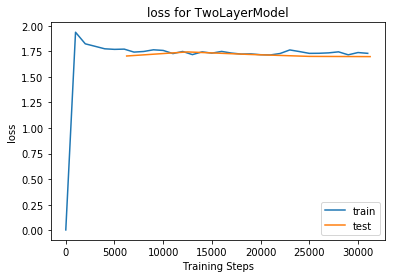

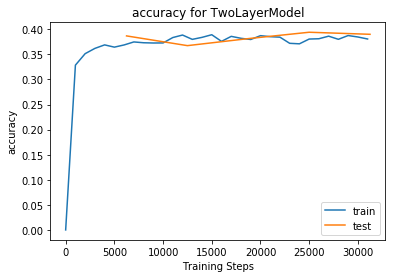

In [0]:
plot_graphs("TwoLayerModel", metrics)

## Part 2 Convolutional Neural Network (CNN) (35 Points)

Now, let's design a convolution neural netwrok!

Build a simple CNN model, inserting 2 CNN layers in from of our 2 layer fully connect model from above:

1. A convolution with	3x3 filter, 16 output channels, stride = 1, padding=1
2. A ReLU activation
2. A Max-Pooling layer with 2x2 window
3. A convolution,	3x3 filter, 16 output channels, stride = 1, padding=1
4. A ReLU activation
4. Flatten layer
5. Fully connected linear layer with output size 64
6. ReLU
7. Fully connected linear layer, with output size 10

You will have to figure out the input sizes of the first fully connnected layer based on the previous layer sizes. Note that you also need to fill those in the report section (see report section in the notebook for details) 

In [0]:
import torch.nn.functional as F
class ConvModel(nn.Module):
  # Your Code Here
  def __init__(self):
    super(ConvModel, self).__init__()
    ##define convolution layers
    self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size = 3,stride=1, padding=1)##Size([8, 16, 32, 32])
    self.conv2 = nn.Conv2d(in_channels=16,out_channels=16,kernel_size = 3,stride=1, padding=1)##Size([8, 16, 16, 16])

    ##define fully connected layers
    self.fc1 = nn.Linear(16*16*16, 64)
    self.fc2 = nn.Linear(64, 10)

    ##define flatten
    self.flatten = Flatten()

  def forward(self, x):
    #Apply convolution1, relu and maxpooling
      x = self.conv1(x)
      x = F.relu(x)
      x = F.max_pool2d(x, (2, 2))##Size([8, 16, 16, 16])

      #Apply convolution2, relu
      x = self.conv2(x)
      x = F.relu(x)

      ##Flatten 
      x = self.flatten(x)
      ##fully connected layers
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      return x

model = ConvModel().to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)

metrics = train(model, train_loader, test_loader, loss, optimizer, training_epochs)

  Epoch 0 @ step 0: Train Loss: 0.004315, Train Accuracy: 0.000125
  Epoch 0 @ step 1000: Train Loss: 1.890718, Train Accuracy: 0.307875
  Epoch 0 @ step 2000: Train Loss: 1.644374, Train Accuracy: 0.403750
  Epoch 0 @ step 3000: Train Loss: 1.537004, Train Accuracy: 0.444875
  Epoch 0 @ step 4000: Train Loss: 1.468599, Train Accuracy: 0.469125
  Epoch 0 @ step 5000: Train Loss: 1.440504, Train Accuracy: 0.479000
  Epoch 0 @ step 6000: Train Loss: 1.422112, Train Accuracy: 0.483125
Epoch 0 Test Loss: 1.347095, Test Accuracy: 0.514400, time: 31.1s
  Epoch 1 @ step 7000: Train Loss: 1.387647, Train Accuracy: 0.498500
  Epoch 1 @ step 8000: Train Loss: 1.398234, Train Accuracy: 0.498125
  Epoch 1 @ step 9000: Train Loss: 1.369328, Train Accuracy: 0.504875
  Epoch 1 @ step 10000: Train Loss: 1.394063, Train Accuracy: 0.502250
  Epoch 1 @ step 11000: Train Loss: 1.367943, Train Accuracy: 0.508875
  Epoch 1 @ step 12000: Train Loss: 1.355605, Train Accuracy: 0.518250
Epoch 1 Test Loss: 1.292

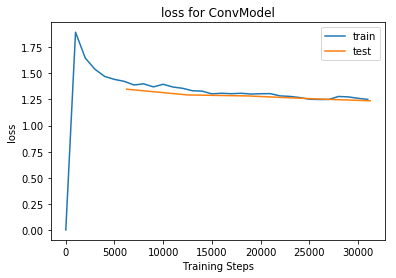

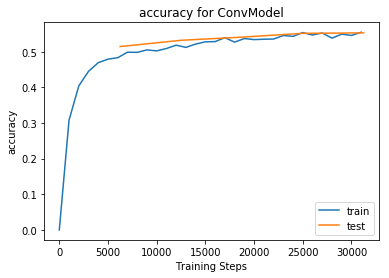

In [0]:
plot_graphs("ConvModel", metrics)

Do you notice the improvement over the accuracy compared to that in Part 1?

Yes, both accuray and loss imporves compred to part 1. 

## Part 3 Open Design Competition (35 Points + 10 bonus points)

Try to beat the previous models by adding additional layers, changing parameters, etc.  You should add at least one layer.

Possible changes include:
*   Dropout
*   Batch Normalization
*   More layers
*   Residual Connections (harder)
*   Change layer size
*   Pooling layers, stride
*   Different optimizer
*   Train for longer

Once you have a model you think is great, evaluate it against our hidden test data (see hidden_loader above) and upload the results to the leader board on gradescope.  **The top 3 scorers will get a bonus 10 points.**

You can steal model structures found on the internet if you want.  The only constraint is that **you must train the model from scratch**.


In [0]:
# You Awesome Super Best model code here

class AwesomeModel(nn.Module ##accuray on learnboard:57.6
  # Your Code Here#
  def __init__(self):
      super(AwesomeModel, self).__init__()
      self.layer1 = nn.Sequential(
          nn.Conv2d(in_channels=3,out_channels=64,kernel_size = 4,stride=2, padding=1),
          nn.ReLU(), 
          nn.MaxPool2d((2,2)))
      self.layer2 = nn.Sequential(
          nn.Conv2d(in_channels=64,out_channels=32,kernel_size = 4,stride=2, padding=1),
          nn.ReLU())
      self.batch = nn.BatchNorm2d(32)
      self.flatten = Flatten()
      self.drop_out = nn.Dropout()
      self.fc1 = nn.Linear(32 * 16, 1000)
      self.fc2 = nn.Linear(1000, 128)
      self.batch1 = nn.BatchNorm1d(128)
      self.fc3 = nn.Linear(128, 10)
      self.batch2 = nn.BatchNorm1d(10)
  def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.batch(x)
      x = self.flatten(x)
      x = self.drop_out(x)
      x = self.fc1(x)
      x = self.fc2(x)
      x = self.batch1(x)
      x = self.fc3(x)
      x = self.batch2(x)
      return x


model = AwesomeModel().to(device)

loss = nn.CrossEntropyLoss()
#optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9, weight_decay=0.01)
metrics = train(model, train_loader, test_loader, loss, optimizer, 35)

  Epoch 0 @ step 0: Train Loss: 0.004148, Train Accuracy: 0.000000
  Epoch 0 @ step 1000: Train Loss: 1.980107, Train Accuracy: 0.285375
  Epoch 0 @ step 2000: Train Loss: 1.807983, Train Accuracy: 0.353375
  Epoch 0 @ step 3000: Train Loss: 1.753441, Train Accuracy: 0.376500
  Epoch 0 @ step 4000: Train Loss: 1.689344, Train Accuracy: 0.393750
  Epoch 0 @ step 5000: Train Loss: 1.679982, Train Accuracy: 0.394625
  Epoch 0 @ step 6000: Train Loss: 1.653118, Train Accuracy: 0.410625
Epoch 0 Test Loss: 1.468760, Test Accuracy: 0.501400, time: 36.6s
  Epoch 1 @ step 7000: Train Loss: 1.635349, Train Accuracy: 0.409875
  Epoch 1 @ step 8000: Train Loss: 1.617652, Train Accuracy: 0.419500
  Epoch 1 @ step 9000: Train Loss: 1.589517, Train Accuracy: 0.431875
  Epoch 1 @ step 10000: Train Loss: 1.582111, Train Accuracy: 0.431375
  Epoch 1 @ step 11000: Train Loss: 1.568108, Train Accuracy: 0.442750
  Epoch 1 @ step 12000: Train Loss: 1.557140, Train Accuracy: 0.448000
Epoch 1 Test Loss: 1.330

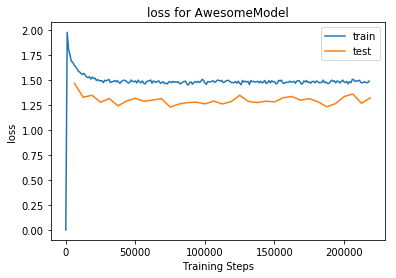

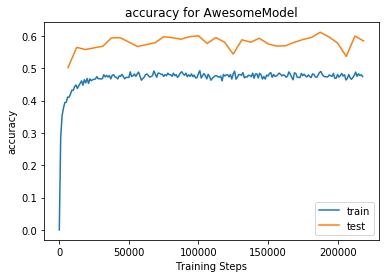

In [0]:
plot_graphs("AwesomeModel", metrics)

In [0]:
import torch.nn.functional as F

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1   = nn.Linear(16*5*5, 120)
    self.fc2   = nn.Linear(120, 84)
    self.fc3   = nn.Linear(84, 10)

  def forward(self, x):
    out = F.relu(self.conv1(x))
    out = F.max_pool2d(out, 2)
    out = F.relu(self.conv2(out))
    out = F.max_pool2d(out, 2)
    out = out.view(out.size(0), -1)
    out = F.relu(self.fc1(out))
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out
lenet = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet.parameters(), lr=0.001, weight_decay=0.01)
metrics = train(lenet, train_loader, test_loader, criterion, optimizer, 10)

  Epoch 0 @ step 0: Train Loss: 0.004310, Train Accuracy: 0.000125
  Epoch 0 @ step 1000: Train Loss: 1.973959, Train Accuracy: 0.256375
  Epoch 0 @ step 2000: Train Loss: 1.749562, Train Accuracy: 0.355625
  Epoch 0 @ step 3000: Train Loss: 1.677375, Train Accuracy: 0.373250
  Epoch 0 @ step 4000: Train Loss: 1.622877, Train Accuracy: 0.400750
  Epoch 0 @ step 5000: Train Loss: 1.559531, Train Accuracy: 0.422875
  Epoch 0 @ step 6000: Train Loss: 1.530584, Train Accuracy: 0.440125
Epoch 0 Test Loss: 1.488903, Test Accuracy: 0.462200, time: 30.0s
  Epoch 1 @ step 7000: Train Loss: 1.504384, Train Accuracy: 0.449375
  Epoch 1 @ step 8000: Train Loss: 1.480378, Train Accuracy: 0.456875
  Epoch 1 @ step 9000: Train Loss: 1.450868, Train Accuracy: 0.470250
  Epoch 1 @ step 10000: Train Loss: 1.443394, Train Accuracy: 0.481375
  Epoch 1 @ step 11000: Train Loss: 1.438972, Train Accuracy: 0.470750
  Epoch 1 @ step 12000: Train Loss: 1.435464, Train Accuracy: 0.476625
Epoch 1 Test Loss: 1.423

In [0]:
from torch.autograd import Variable
import sys
##62.5

def conv3x3(in_planes, out_planes, stride=1):
  return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    init.xavier_uniform(m.weight, gain=np.sqrt(2))
    init.constant(m.bias, 0)

def cfg(depth):
  depth_lst = [18, 34, 50, 101, 152]
  assert (depth in depth_lst), "Error : Resnet depth should be either 18, 34, 50, 101, 152"
  cf_dict = {
      '18': (BasicBlock, [2,2,2,2]),
      '34': (BasicBlock, [3,4,6,3]),
      '50': (Bottleneck, [3,4,6,3]),
      '101':(Bottleneck, [3,4,23,3]),
      '152':(Bottleneck, [3,8,36,3]),
  }

  return cf_dict[str(depth)]

class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
      super(BasicBlock, self).__init__()
      self.conv1 = conv3x3(in_planes, planes, stride)
      self.bn1 = nn.BatchNorm2d(planes)
      self.conv2 = conv3x3(planes, planes)
      self.bn2 = nn.BatchNorm2d(planes)

      self.shortcut = nn.Sequential()
      if stride != 1 or in_planes != self.expansion * planes:
          self.shortcut = nn.Sequential(
              nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=True),
              nn.BatchNorm2d(self.expansion*planes)
          )

  def forward(self, x):
      out = F.relu(self.bn1(self.conv1(x)))
      out = self.bn2(self.conv2(out))
      out += self.shortcut(x)
      out = F.relu(out)

      return out

class Bottleneck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
      super(Bottleneck, self).__init__()
      self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=True)
      self.bn1 = nn.BatchNorm2d(planes)
      self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)
      self.bn2 = nn.BatchNorm2d(planes)
      self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=True)
      self.bn3 = nn.BatchNorm2d(self.expansion*planes)

      self.shortcut = nn.Sequential()
      if stride != 1 or in_planes != self.expansion*planes:
          self.shortcut = nn.Sequential(
              nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=True),
              nn.BatchNorm2d(self.expansion*planes)
          )

  def forward(self, x):
      out = F.relu(self.bn1(self.conv1(x)))
      out = F.relu(self.bn2(self.conv2(out)))
      out = self.bn3(self.conv3(out))
      out += self.shortcut(x)
      out = F.relu(out)

      return out

class ResNet(nn.Module):
  def __init__(self, depth, num_classes):
      super(ResNet, self).__init__()
      self.in_planes = 16

      block, num_blocks = cfg(depth)

      self.conv1 = conv3x3(3,16)
      self.bn1 = nn.BatchNorm2d(16)
      self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
      self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
      self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
      self.linear = nn.Linear(64*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
      strides = [stride] + [1]*(num_blocks-1)
      layers = []

      for stride in strides:
          layers.append(block(self.in_planes, planes, stride))
          self.in_planes = planes * block.expansion

      return nn.Sequential(*layers)

  def forward(self, x):
      out = F.relu(self.bn1(self.conv1(x)))
      out = self.layer1(out)
      out = self.layer2(out)
      out = self.layer3(out)
      out = F.avg_pool2d(out, 8)
      out = out.view(out.size(0), -1)
      out = self.linear(out)

      return out
resnet = ResNet(18,10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001, weight_decay=0.01)
metrics = train(resnet, train_loader, test_loader, criterion, optimizer, 10)

  Epoch 0 @ step 0: Train Loss: 0.004280, Train Accuracy: 0.000250
  Epoch 0 @ step 1000: Train Loss: 1.924105, Train Accuracy: 0.271250
  Epoch 0 @ step 2000: Train Loss: 1.773892, Train Accuracy: 0.341250
  Epoch 0 @ step 3000: Train Loss: 1.693985, Train Accuracy: 0.369375
  Epoch 0 @ step 4000: Train Loss: 1.613768, Train Accuracy: 0.401125
  Epoch 0 @ step 5000: Train Loss: 1.572967, Train Accuracy: 0.428125
  Epoch 0 @ step 6000: Train Loss: 1.527561, Train Accuracy: 0.441000
Epoch 0 Test Loss: 1.415814, Test Accuracy: 0.483600, time: 92.4s
  Epoch 1 @ step 7000: Train Loss: 1.498398, Train Accuracy: 0.455125
  Epoch 1 @ step 8000: Train Loss: 1.488238, Train Accuracy: 0.464750
  Epoch 1 @ step 9000: Train Loss: 1.491235, Train Accuracy: 0.461875
  Epoch 1 @ step 10000: Train Loss: 1.443816, Train Accuracy: 0.474375
  Epoch 1 @ step 11000: Train Loss: 1.440133, Train Accuracy: 0.486625
  Epoch 1 @ step 12000: Train Loss: 1.416566, Train Accuracy: 0.494250
Epoch 1 Test Loss: 1.303

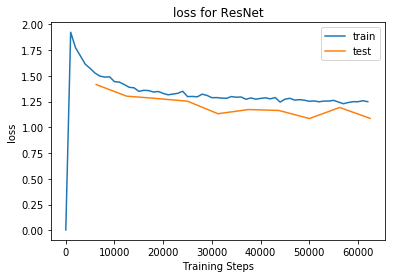

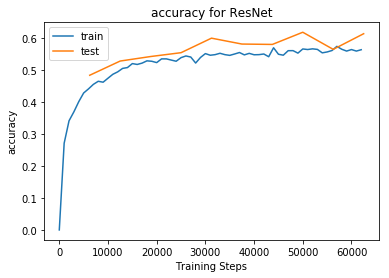

In [0]:
plot_graphs("ResNet", metrics)

In [0]:
##60.0
def conv3x3(in_planes, out_planes, stride=1):
  return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    init.xavier_uniform(m.weight, gain=np.sqrt(2))
    init.constant(m.bias, 0)

def cfg(depth):
  depth_lst = [18, 34, 50, 101, 152]
  assert (depth in depth_lst), "Error : Resnet depth should be either 18, 34, 50, 101, 152"
  cf_dict = {
      '18': (BasicBlock, [2,2,2,2]),
      '34': (BasicBlock, [3,4,6,3]),
      '50': (Bottleneck, [3,4,6,3]),
      '101':(Bottleneck, [3,4,23,3]),
      '152':(Bottleneck, [3,8,36,3]),
  }

  return cf_dict[str(depth)]

class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
      super(BasicBlock, self).__init__()
      self.conv1 = conv3x3(in_planes, planes, stride)
      self.bn1 = nn.BatchNorm2d(planes)
      self.conv2 = conv3x3(planes, planes)
      self.bn2 = nn.BatchNorm2d(planes)

      self.shortcut = nn.Sequential()
      if stride != 1 or in_planes != self.expansion * planes:
          self.shortcut = nn.Sequential(
              nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=True),
              nn.BatchNorm2d(self.expansion*planes)
          )

  def forward(self, x):
      out = F.relu(self.bn1(self.conv1(x)))
      out = self.bn2(self.conv2(out))
      out += self.shortcut(x)
      out = F.relu(out)

      return out

class Bottleneck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
      super(Bottleneck, self).__init__()
      self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=True)
      self.bn1 = nn.BatchNorm2d(planes)
      self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)
      self.bn2 = nn.BatchNorm2d(planes)
      self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=True)
      self.bn3 = nn.BatchNorm2d(self.expansion*planes)

      self.shortcut = nn.Sequential()
      if stride != 1 or in_planes != self.expansion*planes:
          self.shortcut = nn.Sequential(
              nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=True),
              nn.BatchNorm2d(self.expansion*planes)
          )

  def forward(self, x):
      out = F.relu(self.bn1(self.conv1(x)))
      out = F.relu(self.bn2(self.conv2(out)))
      out = self.bn3(self.conv3(out))
      out += self.shortcut(x)
      out = F.relu(out)

      return out

class ResNet(nn.Module):
  def __init__(self, depth, num_classes):
      super(ResNet, self).__init__()
      self.in_planes = 16

      block, num_blocks = cfg(depth)

      self.conv1 = conv3x3(3,16)
      self.bn1 = nn.BatchNorm2d(16)
      self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
      self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
      self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
      self.linear = nn.Linear(64*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
      strides = [stride] + [1]*(num_blocks-1)
      layers = []

      for stride in strides:
          layers.append(block(self.in_planes, planes, stride))
          self.in_planes = planes * block.expansion

      return nn.Sequential(*layers)

  def forward(self, x):
      out = F.relu(self.bn1(self.conv1(x)))
      out = self.layer1(out)
      out = self.layer2(out)
      out = self.layer3(out)
      out = F.avg_pool2d(out, 8)
      out = out.view(out.size(0), -1)
      out = self.linear(out)

      return out
resnet2 = ResNet(50,10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet2.parameters(), lr=0.001, weight_decay=0.01)
metrics = train(resnet2, train_loader, test_loader, criterion, optimizer, 30)

  Epoch 0 @ step 0: Train Loss: 0.004228, Train Accuracy: 0.000125
  Epoch 0 @ step 1000: Train Loss: 1.954915, Train Accuracy: 0.256625
  Epoch 0 @ step 2000: Train Loss: 1.850750, Train Accuracy: 0.294750
  Epoch 0 @ step 3000: Train Loss: 1.801835, Train Accuracy: 0.314000
  Epoch 0 @ step 4000: Train Loss: 1.752429, Train Accuracy: 0.337750
  Epoch 0 @ step 5000: Train Loss: 1.698903, Train Accuracy: 0.355750
  Epoch 0 @ step 6000: Train Loss: 1.654082, Train Accuracy: 0.367375
Epoch 0 Test Loss: 1.640948, Test Accuracy: 0.393200, time: 218.9s
  Epoch 1 @ step 7000: Train Loss: 1.657836, Train Accuracy: 0.387250
  Epoch 1 @ step 8000: Train Loss: 1.623331, Train Accuracy: 0.394625
  Epoch 1 @ step 9000: Train Loss: 1.607507, Train Accuracy: 0.398750
  Epoch 1 @ step 10000: Train Loss: 1.587097, Train Accuracy: 0.415875
  Epoch 1 @ step 11000: Train Loss: 1.578323, Train Accuracy: 0.422125
  Epoch 1 @ step 12000: Train Loss: 1.562192, Train Accuracy: 0.414625
Epoch 1 Test Loss: 1.48

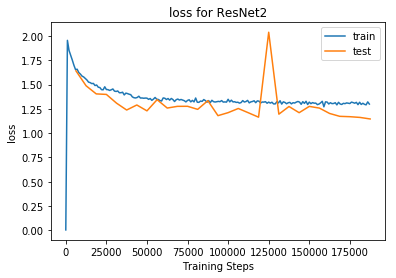

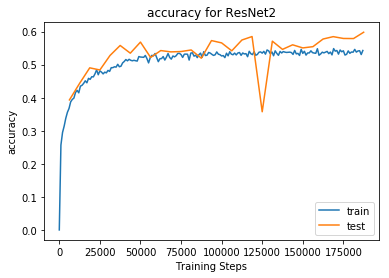

In [0]:
plot_graphs("ResNet2", metrics)

In [0]:
# You Awesome Super Best model code here
class AwesomeModel(nn.Module):  ###accuracy on learnboard:59.8
  # Your Code Here#
  def __init__(self):
      super(AwesomeModel, self).__init__()
      self.layer1 = nn.Sequential(
          nn.Conv2d(in_channels=3,out_channels=64,kernel_size = 3,stride=2, padding=1),
          nn.ReLU(), 
          nn.MaxPool2d((2,2)))
      self.layer2 = nn.Sequential(
          nn.Conv2d(in_channels=64,out_channels=16,kernel_size = 3,stride=2, padding=1),
          nn.ReLU())
      self.batch = nn.BatchNorm2d(16)
      self.flatten = Flatten()
      self.drop_out = nn.Dropout()
      self.fc1 = nn.Linear(16*16, 512)
      self.fc2 = nn.Linear(512, 128)
      self.fc3 = nn.Linear(128, 10)
  def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.batch(x)
      x = self.flatten(x)
      x = self.drop_out(x)
      x = self.fc1(x)
      x = self.fc2(x)
      x = self.fc3(x)
      return x


model = AwesomeModel().to(device)

loss = nn.CrossEntropyLoss()
#optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9, weight_decay=0.01)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
metrics = train(model, train_loader, test_loader, loss, optimizer, 15)

In [0]:
def flatten(x): 
  return x.view(x.size(0), -1)


def conv3x3(in_planes, out_planes, stride=1):
  "3x3 convolution with padding"
  return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)



class BasicBlock(nn.Module):
  expansion = 1       

  def __init__(self, in_planes, planes, stride=1, downsample=None):
      super(BasicBlock, self).__init__()

      self.conv1 = conv3x3(in_planes, planes, stride)
      self.conv2 = conv3x3(planes, planes)

      self.bn1 = nn.BatchNorm2d(planes)
      self.bn2 = nn.BatchNorm2d(planes)

      self.relu = nn.ReLU(inplace=True)
      self.downsample = downsample

      self.stride = stride

  def forward(self, x):

      residue = x
      out = self.relu(self.bn1(self.conv1(x)))
      out = self.bn2(self.conv2(out))

      if self.downsample is not None:
          residue = self.downsample(x)

      out += residue
      out = self.relu(out)
      return out


class Bottleneck(nn.Module):
    
  expansion = 4

  def __init__(self, in_planes, planes, stride=1, downsample=None):
      super(Bottleneck, self).__init__()
      self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
      self.bn1 = nn.BatchNorm2d(planes)

      self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
      self.bn2 = nn.BatchNorm2d(planes)

      self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
      self.bn3 = nn.BatchNorm2d(self.expansion*planes)

      self.downsample = downsample

      self.stride = stride

  def forward(self, x):

      residue = x
      out = self.relu(self.bn1(self.conv1(x)))
      out = self.relu(self.bn2(self.conv2(x)))
      out = self.bn3(self.conv3(out))

      if self.downsample is not None:
          residue = self.downsample(x)

      out += residue
      out = self.relu(out)
      return out
            
            
class ResNet(nn.Module):

  def __init__(self, depth, name, num_classes=10, block=BasicBlock):
      super(ResNet, self).__init__()

      assert (depth - 2) % 6 == 0, 'Depth should be 6n + 2'
      n = (depth - 2) // 6

      self.name = name
      block = BasicBlock
      self.inplanes = 16
      fmaps = [16, 32, 64] # CIFAR10

      self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
      self.bn = nn.BatchNorm2d(16)
      self.relu = nn.ReLU(inplace=True)

      self.layer1 = self._make_layer(block, fmaps[0], n, stride=1)
      self.layer2 = self._make_layer(block, fmaps[1], n, stride=2)
      self.layer3 = self._make_layer(block, fmaps[2], n, stride=2)

      self.avgpool = nn.AvgPool2d(kernel_size=8, stride=1)
      self.flatten = flatten
      self.fc = nn.Linear(fmaps[2] * block.expansion, num_classes)

      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
          elif isinstance(m, nn.BatchNorm2d):
              nn.init.constant_(m.weight, 1)
              nn.init.constant_(m.bias, 0)

  def _make_layer(self, block, planes, blocks, stride=1):
      ''' Between layers convolve input to match dimensions -> stride = 2 '''

      downsample = None
      if stride != 1 or self.inplanes != planes * block.expansion:
          downsample = nn.Sequential(
                  nn.Conv2d(self.inplanes, planes * block.expansion,
                            kernel_size=1, stride=stride, bias=False),
                  nn.BatchNorm2d(planes * block.expansion))

      layers = []
      layers.append(block(self.inplanes, planes, stride, downsample))
      self.inplanes = planes * block.expansion
      for _ in range(1, blocks):
          layers.append(block(self.inplanes, planes))

      return nn.Sequential(*layers)


  def forward(self, x, print_sizes=False):

      if print_sizes:
          print('Sizes of the tensors inside each node: \n')
          print("\t In Model: input size", x.size())

      x = self.relu(self.bn(self.conv(x)))    # 32x32

      x = self.layer1(x)                      # 32x32
      x = self.layer2(x)                      # 16x16
      x = self.layer3(x)                      # 8x8

      x = self.avgpool(x)                     # 1x1
      x = self.flatten(x)                     # Flatten
      x  = self.fc(x)                         # Dense

      if print_sizes:
          print("\t In Model: output size", x.size())

      return x



def ResNet20(**kwargs): 
  return ResNet(name = 'ResNet20', depth = 20, **kwargs)

def ResNet32(**kwargs):
  return ResNet(name = 'ResNet32', depth = 32, **kwargs)

def ResNet44(**kwargs):
  return ResNet(name = 'ResNet44', depth = 44, **kwargs)

def ResNet56(**kwargs):
  return ResNet(name = 'ResNet56', depth = 56, **kwargs)

def ResNet110(**kwargs):
  return ResNet(name = 'ResNet110', depth = 110, **kwargs)


    
resnet20 = ResNet20().to(device)  ###76.8
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(resnet20.parameters(), lr = 0.001, momentum = 0.9, weight_decay=0.01)
metrics = train(resnet20, train_loader, test_loader, criterion, optimizer, 10)

  Epoch 0 @ step 0: Train Loss: 0.004216, Train Accuracy: 0.000000
  Epoch 0 @ step 1000: Train Loss: 2.013260, Train Accuracy: 0.237375
  Epoch 0 @ step 2000: Train Loss: 1.756539, Train Accuracy: 0.341750
  Epoch 0 @ step 3000: Train Loss: 1.662056, Train Accuracy: 0.387125
  Epoch 0 @ step 4000: Train Loss: 1.575364, Train Accuracy: 0.420875
  Epoch 0 @ step 5000: Train Loss: 1.498391, Train Accuracy: 0.453875
  Epoch 0 @ step 6000: Train Loss: 1.429794, Train Accuracy: 0.483000
Epoch 0 Test Loss: 1.326770, Test Accuracy: 0.516100, time: 83.2s
  Epoch 1 @ step 7000: Train Loss: 1.362422, Train Accuracy: 0.513125
  Epoch 1 @ step 8000: Train Loss: 1.303761, Train Accuracy: 0.532375
  Epoch 1 @ step 9000: Train Loss: 1.279390, Train Accuracy: 0.541500
  Epoch 1 @ step 10000: Train Loss: 1.254380, Train Accuracy: 0.554750
  Epoch 1 @ step 11000: Train Loss: 1.207081, Train Accuracy: 0.575500
  Epoch 1 @ step 12000: Train Loss: 1.196090, Train Accuracy: 0.577125
Epoch 1 Test Loss: 1.068

In [0]:
def flatten(x): 
  return x.view(x.size(0), -1)


def conv3x3(in_planes, out_planes, stride=1):
  "3x3 convolution with padding"
  return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)



class BasicBlock(nn.Module):
  expansion = 1       

  def __init__(self, in_planes, planes, stride=1, downsample=None):
      super(BasicBlock, self).__init__()

      self.conv1 = conv3x3(in_planes, planes, stride)
      self.conv2 = conv3x3(planes, planes)

      self.bn1 = nn.BatchNorm2d(planes)
      self.bn2 = nn.BatchNorm2d(planes)

      self.relu = nn.ReLU(inplace=True)
      self.downsample = downsample

      self.stride = stride

  def forward(self, x):

      residue = x
      out = self.relu(self.bn1(self.conv1(x)))
      out = self.bn2(self.conv2(out))

      if self.downsample is not None:
          residue = self.downsample(x)

      out += residue
      out = self.relu(out)
      return out


class Bottleneck(nn.Module):
    
  expansion = 4

  def __init__(self, in_planes, planes, stride=1, downsample=None):
      super(Bottleneck, self).__init__()
      self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
      self.bn1 = nn.BatchNorm2d(planes)

      self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
      self.bn2 = nn.BatchNorm2d(planes)

      self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
      self.bn3 = nn.BatchNorm2d(self.expansion*planes)

      self.downsample = downsample
      self.relu = nn.ReLU(inplace = True)

      self.stride = stride

  def forward(self, x):

      residue = x
      out = self.relu(self.bn1(self.conv1(x)))
      out = self.relu(self.bn2(self.conv2(out)))
      out = self.bn3(self.conv3(out))

      if self.downsample is not None:
          residue = self.downsample(x)

      out += residue
      out = self.relu(out)
      return out
            
            
class ResNet(nn.Module):

  def __init__(self, depth, name, num_classes=10, block=Bottleneck):
      super(ResNet, self).__init__()

      assert (depth - 2) % 6 == 0, 'Depth should be 6n + 2'
      n = (depth - 2) // 6

      self.name = name
      block = Bottleneck
      self.inplanes = 16
      fmaps = [16, 32, 64] # CIFAR10

      self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False)
      self.bn = nn.BatchNorm2d(16)
      self.relu = nn.ReLU(inplace=True)

      self.layer1 = self._make_layer(block, fmaps[0], n, stride=1)
      self.layer2 = self._make_layer(block, fmaps[1], n, stride=2)
      self.layer3 = self._make_layer(block, fmaps[2], n, stride=2)

      self.avgpool = nn.AvgPool2d(kernel_size=8)
      self.flatten = flatten
      self.fc = nn.Linear(fmaps[2] * block.expansion, num_classes)

      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
          elif isinstance(m, nn.BatchNorm2d):
              nn.init.constant_(m.weight, 1)
              nn.init.constant_(m.bias, 0)

  def _make_layer(self, block, planes, blocks, stride=1):
      ''' Between layers convolve input to match dimensions -> stride = 2 '''

      downsample = None
      if stride != 1 or self.inplanes != planes * block.expansion:
          downsample = nn.Sequential(
                  nn.Conv2d(self.inplanes, planes * block.expansion,
                            kernel_size=1, stride=stride, bias=False),
                  nn.BatchNorm2d(planes * block.expansion))

      layers = []
      layers.append(block(self.inplanes, planes, stride, downsample))
      self.inplanes = planes * block.expansion
      for _ in range(1, blocks):
          layers.append(block(self.inplanes, planes))

      return nn.Sequential(*layers)


  def forward(self, x):


      x = self.relu(self.bn(self.conv(x)))    # 16x16

      x = self.layer1(x)                      # 16x16
      x = self.layer2(x)                      # 8x8
      x = self.layer3(x)                      # 4x4

      x = self.avgpool(x)                     # 1x1
      x = self.flatten(x)                     # Flatten
      x  = self.fc(x)                         # Dense

      return x



def ResNet20(**kwargs): 
  return ResNet(name = 'ResNet20', depth = 20, **kwargs)

def ResNet32(**kwargs):
  return ResNet(name = 'ResNet32', depth = 32, **kwargs)

def ResNet44(**kwargs):
  return ResNet(name = 'ResNet44', depth = 44, **kwargs)

def ResNet56(**kwargs):
  return ResNet(name = 'ResNet56', depth = 56, **kwargs)

def ResNet110(**kwargs):
  return ResNet(name = 'ResNet110', depth = 110, **kwargs)


    
resnet20 = ResNet20().to(device)  ###
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(resnet20.parameters(), lr = 0.001, momentum = 0.9, weight_decay=0.01)
metrics_ = train(resnet20, train_loader, test_loader, criterion, optimizer, 10)

  Epoch 0 @ step 0: Train Loss: 0.004572, Train Accuracy: 0.000125
  Epoch 0 @ step 1000: Train Loss: 2.132992, Train Accuracy: 0.193125
  Epoch 0 @ step 2000: Train Loss: 1.943822, Train Accuracy: 0.272500
  Epoch 0 @ step 3000: Train Loss: 1.826140, Train Accuracy: 0.318750
  Epoch 0 @ step 4000: Train Loss: 1.731302, Train Accuracy: 0.362125
  Epoch 0 @ step 5000: Train Loss: 1.642652, Train Accuracy: 0.394250
  Epoch 0 @ step 6000: Train Loss: 1.614814, Train Accuracy: 0.406875
Epoch 0 Test Loss: 1.498054, Test Accuracy: 0.447600, time: 119.3s
  Epoch 1 @ step 7000: Train Loss: 1.552962, Train Accuracy: 0.434625
  Epoch 1 @ step 8000: Train Loss: 1.512548, Train Accuracy: 0.446125
  Epoch 1 @ step 9000: Train Loss: 1.458781, Train Accuracy: 0.470875
  Epoch 1 @ step 10000: Train Loss: 1.424330, Train Accuracy: 0.490375
  Epoch 1 @ step 11000: Train Loss: 1.413065, Train Accuracy: 0.491500
  Epoch 1 @ step 12000: Train Loss: 1.375146, Train Accuracy: 0.510625
Epoch 1 Test Loss: 1.19

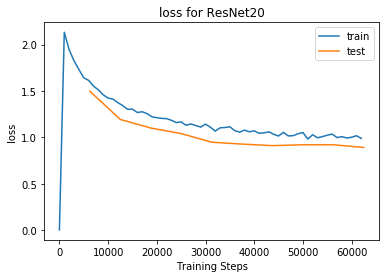

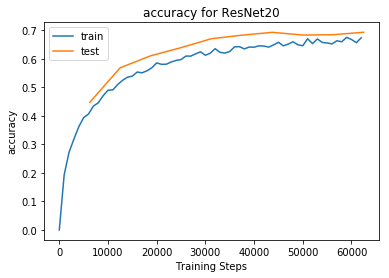

In [0]:
plot_graphs("ResNet20", metrics_)

In [0]:
class ResidualBlock(nn.Module):
  def __init__(self, inchannel, outchannel, stride=1):
    super(ResidualBlock, self).__init__()
    self.left = nn.Sequential(
        nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(outchannel),
        nn.ReLU(inplace=True),
        nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(outchannel)
    )
    self.shortcut = nn.Sequential()
    if stride != 1 or inchannel != outchannel:
        self.shortcut = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(outchannel)
        )
  def forward(self, x):
    out = self.left(x)
    out += self.shortcut(x)
    out = F.relu(out)
    return out
class ResNet(nn.Module):
  def __init__(self, ResidualBlock, num_classes=10):
    super(ResNet, self).__init__()
    self.inchannel = 64
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
    )
    self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
    self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
    self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
    self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
    self.fc = nn.Linear(512, num_classes)

  def make_layer(self, block, channels, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
    layers = []
    for stride in strides:
        layers.append(block(self.inchannel, channels, stride))
        self.inchannel = channels
    return nn.Sequential(*layers)
  def forward(self, x):
    out = self.conv1(x)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.fc(out)
    return out


def ResNet18():
  return ResNet(ResidualBlock)
modelnew = ResNet18().to(device)  ###78.3
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(modelnew.parameters(), lr = 0.001, momentum = 0.9, weight_decay=0.01)
metrics_ = train(modelnew, train_loader, test_loader, criterion, optimizer, 10)

  Epoch 0 @ step 0: Train Loss: 0.004372, Train Accuracy: 0.000125
  Epoch 0 @ step 1000: Train Loss: 1.804645, Train Accuracy: 0.332625
  Epoch 0 @ step 2000: Train Loss: 1.514506, Train Accuracy: 0.445000
  Epoch 0 @ step 3000: Train Loss: 1.333483, Train Accuracy: 0.530375
  Epoch 0 @ step 4000: Train Loss: 1.217202, Train Accuracy: 0.572000
  Epoch 0 @ step 5000: Train Loss: 1.142842, Train Accuracy: 0.599500
  Epoch 0 @ step 6000: Train Loss: 1.068641, Train Accuracy: 0.624000
Epoch 0 Test Loss: 0.976825, Test Accuracy: 0.660400, time: 131.5s
  Epoch 1 @ step 7000: Train Loss: 1.001310, Train Accuracy: 0.658750
  Epoch 1 @ step 8000: Train Loss: 0.954892, Train Accuracy: 0.671125
  Epoch 1 @ step 9000: Train Loss: 0.941799, Train Accuracy: 0.682125
  Epoch 1 @ step 10000: Train Loss: 0.931520, Train Accuracy: 0.685750
  Epoch 1 @ step 11000: Train Loss: 0.899666, Train Accuracy: 0.693500
  Epoch 1 @ step 12000: Train Loss: 0.873269, Train Accuracy: 0.708625
Epoch 1 Test Loss: 0.83

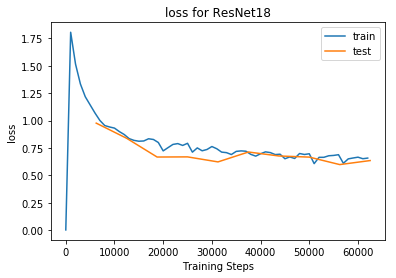

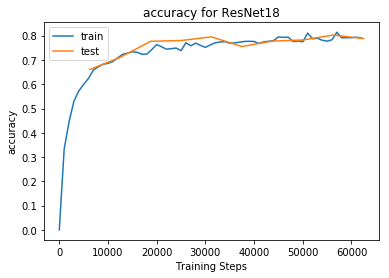

In [0]:
plot_graphs("ResNet18", metrics_)

In [0]:
modelnew_ = ResNet18().to(device)  ###79.2
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(modelnew_.parameters(), lr = 0.001, momentum = 0.9, weight_decay=0.01)
metrics_ = train(modelnew_, train_loader, test_loader, criterion, optimizer, 9)

  Epoch 0 @ step 0: Train Loss: 0.004407, Train Accuracy: 0.000000
  Epoch 0 @ step 1000: Train Loss: 1.826657, Train Accuracy: 0.319125
  Epoch 0 @ step 2000: Train Loss: 1.540532, Train Accuracy: 0.441250
  Epoch 0 @ step 3000: Train Loss: 1.383436, Train Accuracy: 0.506750
  Epoch 0 @ step 4000: Train Loss: 1.231417, Train Accuracy: 0.561500
  Epoch 0 @ step 5000: Train Loss: 1.156108, Train Accuracy: 0.598375
  Epoch 0 @ step 6000: Train Loss: 1.079574, Train Accuracy: 0.616750
Epoch 0 Test Loss: 1.020162, Test Accuracy: 0.637900, time: 131.2s
  Epoch 1 @ step 7000: Train Loss: 1.023239, Train Accuracy: 0.643125
  Epoch 1 @ step 8000: Train Loss: 0.941610, Train Accuracy: 0.678125
  Epoch 1 @ step 9000: Train Loss: 0.953219, Train Accuracy: 0.672625
  Epoch 1 @ step 10000: Train Loss: 0.917444, Train Accuracy: 0.691750
  Epoch 1 @ step 11000: Train Loss: 0.921458, Train Accuracy: 0.686000
  Epoch 1 @ step 12000: Train Loss: 0.890602, Train Accuracy: 0.704125
Epoch 1 Test Loss: 0.78

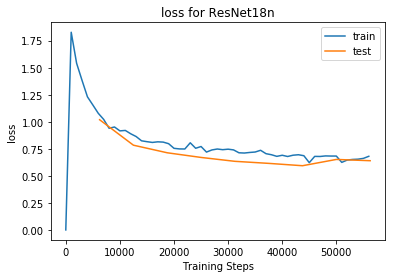

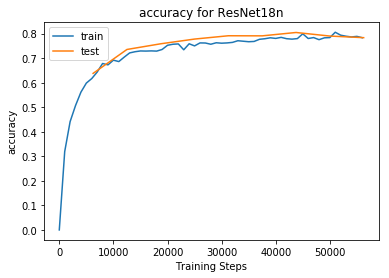

In [0]:
plot_graphs("ResNet18n", metrics_)

In [11]:
class ResidualBlock(nn.Module):
  def __init__(self, inchannel, outchannel, stride=1):
    super(ResidualBlock, self).__init__()
    self.left = nn.Sequential(
        nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(outchannel),
        nn.ReLU(inplace=True),
        nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(outchannel)
    )
    self.shortcut = nn.Sequential()
    if stride != 1 or inchannel != outchannel:
        self.shortcut = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(outchannel)
        )
  def forward(self, x):
    out = self.left(x)
    out += self.shortcut(x)
    out = F.relu(out)
    return out
class ResNet(nn.Module):
  def __init__(self, ResidualBlock, num_classes=10):
    super(ResNet, self).__init__()
    self.inchannel = 64
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
    )
    self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
    self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
    self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
    self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
    self.fc = nn.Linear(512, num_classes)

  def make_layer(self, block, channels, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
    layers = []
    for stride in strides:
        layers.append(block(self.inchannel, channels, stride))
        self.inchannel = channels
    return nn.Sequential(*layers)
  def forward(self, x):
    out = self.conv1(x)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.fc(out)
    return out


def ResNet18():
  return ResNet(ResidualBlock)

modelnew_ = ResNet18().to(device)  ###
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(modelnew_.parameters(), lr = 0.001, momentum = 0.9, weight_decay=0.01)
metrics_ = train(modelnew_, train_loader, test_loader, criterion, optimizer, 50)

  Epoch 0 @ step 0: Train Loss: 0.004337, Train Accuracy: 0.000000
  Epoch 0 @ step 1000: Train Loss: 1.802889, Train Accuracy: 0.329375
  Epoch 0 @ step 2000: Train Loss: 1.540564, Train Accuracy: 0.444250
  Epoch 0 @ step 3000: Train Loss: 1.371203, Train Accuracy: 0.514375
  Epoch 0 @ step 4000: Train Loss: 1.266505, Train Accuracy: 0.549375
  Epoch 0 @ step 5000: Train Loss: 1.141689, Train Accuracy: 0.596250
  Epoch 0 @ step 6000: Train Loss: 1.069220, Train Accuracy: 0.630625
Epoch 0 Test Loss: 0.924513, Test Accuracy: 0.682900, time: 129.7s
  Epoch 1 @ step 7000: Train Loss: 1.000708, Train Accuracy: 0.656375
  Epoch 1 @ step 8000: Train Loss: 0.969487, Train Accuracy: 0.672125
  Epoch 1 @ step 9000: Train Loss: 0.933725, Train Accuracy: 0.686875
  Epoch 1 @ step 10000: Train Loss: 0.931493, Train Accuracy: 0.687500
  Epoch 1 @ step 11000: Train Loss: 0.905032, Train Accuracy: 0.697250
  Epoch 1 @ step 12000: Train Loss: 0.891164, Train Accuracy: 0.701250
Epoch 1 Test Loss: 0.77

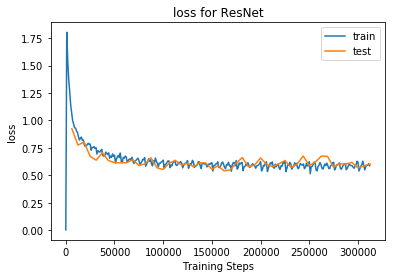

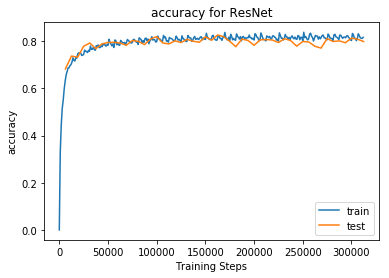

In [12]:
plot_graphs("ResNet", metrics_)

**What changes did you make to improve your model?**

After you get a nice model, download the test_file.zip and unzip it to get test_file.pt. In colab, you can explore your files from the left side bar. You can also download the files to your machine from there.

In [13]:
!wget http://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
!unzip test_file.zip

--2019-04-24 00:02:51--  http://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
Resolving courses.engr.illinois.edu (courses.engr.illinois.edu)... 130.126.151.9
Connecting to courses.engr.illinois.edu (courses.engr.illinois.edu)|130.126.151.9|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip [following]
--2019-04-24 00:02:51--  https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/test_file.zip
Connecting to courses.engr.illinois.edu (courses.engr.illinois.edu)|130.126.151.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3841776 (3.7M) [application/x-zip-compressed]
Saving to: ‘test_file.zip.1’

test_file.zip.1     100%[===================>]   3.66M  13.6MB/s    in 0.3s    

2019-04-24 00:02:52 (13.6 MB/s) - ‘test_file.zip.1’ saved [3841776/3841776]

Archive:  test_file.zip
replace test_file.pt? [y]es, [n]o, [A]ll, [N]one, 

Then use your model to predict the label of the test images. Fill the remaining code below, where x has two dimensions (batch_size x one image size). Remember to reshpe x accordingly before feeding it into your model. The submission.txt should contain one predicted label (0~9) each line. Submit your submission.txt to the competition in gradscope.

In [0]:
import torch.utils.data as Data

test_file = 'test_file.pt'
pred_file = 'submission.txt'

f_pred = open(pred_file,'w') 
tensor = torch.load(test_file)
torch_dataset = Data.TensorDataset(tensor)  
test_loader2 = torch.utils.data.DataLoader(torch_dataset, batch_size, shuffle=False, num_workers=2)

for ele in test_loader2:
    x = ele[0]
    # Fill your code here
    x = x.reshape(batch_size,3,32,32)
    predict = modelnew_(x.to(device))
    labels = torch.argmax(predict, dim = 1)
    for i in labels:
      f_pred.write(str(i.item()))
      f_pred.write('\n')
    
f_pred.close()


# Report

## Part 0: Imports and Basic Setup (5 Points)
Nothing to report for this part. You will be just scored for finishing the setup.

## Part 1: Fully connected neural networks (25 Points)

Test (on validation set) accuracy (5 Points):

Test loss (5 Points):

Training time (5 Points):


Plots:

- Plot a graph of accuracy on validation set vs epoch (5 Points)

- Plot a graph of loss on validation set vs epoch (5 Points)


## Part 2: Convolution Network (Basic) (35 Points)

Tensor dimensions: A good way to debug your network for size mismatches is to print the dimension of output after every layers:

(10 Points)

Output dimension after 1st conv layer: 

Output dimension after 1st max pooling: 

Output dimension after 2nd conv layer: 

Output dimension after 2nd max pooling:

Output dimension after 1st fully connected layer:

Output dimension after 2nd fully connected layer:

Output dimension after 3rd fully connected layer:


Test (on validation set) Accuracy (5 Points):

Test loss (5 Points):

Training time (5 Points):


Plots:

- Plot a graph of accuracy on validation set vs epoch (5 Points)

- Plot a graph of loss on validation set vs epoch (5 Points)



## Part 3: Convolution Network (Add one or more  suggested changes) (35 Points)

Describe the additional changes implemented, your intuition for as to why it works, you may also describe other approaches you experimented with (10 Points):


Test (on validation set) Accuracy (5 Points):

Test loss (5 Points):

Training time (5 Points):


Plots:

- Plot a graph of accuracy on validation set vs epoch (5 Points)

- Plot a graph of loss on validation set vs epoch (5 Points)

10 bonus points will be awarded to top 3 scorers on leaderboard (in case of tie for 3rd position everyone tied for 3rd position will get the bonus)